本次，二分类，我的操作主要分为以下四个部分：
> 1. 导入相关的包和数据集
> 2. 数据预处理
> 3. Exploratory Data Analysis
> 4. 模型建立和调参

# 1. 导入相关的包和数据集

In [1]:
# package imports
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
# load train data to play with 
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

# 因为训练集是没有打乱的，所以我shuffle了一下，不过不shuffle也没有关系
from sklearn.utils import shuffle
train = shuffle(train)

print(train.head())
print(test.head())
print(train.shape)
print(test.shape)

          ID  age          job   marital  education default  balance housing  \
8243    8244   44   management   married  secondary      no      576     yes   
15389  15390   47  blue-collar   married  secondary      no      762     yes   
3832    3833   41   management  divorced   tertiary      no       47     yes   
18562  18563   54   management  divorced   tertiary      no       22      no   
15715  15716   36     services   married  secondary      no      372      no   

      loan   contact  day month  duration  campaign  pdays  previous poutcome  \
8243    no   unknown    8   may       128         3     -1         0  unknown   
15389   no   unknown   29   may        56         3     -1         0  unknown   
3832    no   unknown    8   may       160         1     -1         0  unknown   
18562  yes  cellular   18   jul       259         3     -1         0  unknown   
15715   no  cellular    4   feb        94         1     -1         0  unknown   

       y  
8243   0  
15389  0  

加载数据集之后，我发现：
>1. 训练集一共有25,317个observations，18columns。因为第一个column是 `ID`，和`y`无关，因此，我会将其移除
>2. 测试集一共有10,852个observations, 17columns。因为第一个column是 `ID`，和`y`无关，因此，我会将其移除

In [3]:
train.drop(columns = ['ID'], inplace = True)
test.drop(columns = ['ID'], inplace = True)

接下来，我会使用`info`来对`train`和`test`的数据类型进行了解

In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25317 entries, 8243 to 13335
Data columns (total 17 columns):
age          25317 non-null int64
job          25317 non-null object
marital      25317 non-null object
education    25317 non-null object
default      25317 non-null object
balance      25317 non-null int64
housing      25317 non-null object
loan         25317 non-null object
contact      25317 non-null object
day          25317 non-null int64
month        25317 non-null object
duration     25317 non-null int64
campaign     25317 non-null int64
pdays        25317 non-null int64
previous     25317 non-null int64
poutcome     25317 non-null object
y            25317 non-null int64
dtypes: int64(8), object(9)
memory usage: 3.5+ MB
None


In [5]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10852 entries, 0 to 10851
Data columns (total 16 columns):
age          10852 non-null int64
job          10852 non-null object
marital      10852 non-null object
education    10852 non-null object
default      10852 non-null object
balance      10852 non-null int64
housing      10852 non-null object
loan         10852 non-null object
contact      10852 non-null object
day          10852 non-null int64
month        10852 non-null object
duration     10852 non-null int64
campaign     10852 non-null int64
pdays        10852 non-null int64
previous     10852 non-null int64
poutcome     10852 non-null object
dtypes: int64(7), object(9)
memory usage: 1.3+ MB
None


通过，观察训练集，我发现：
>1. 训练集一共有25317个entries
2. 训练集的数据比较完整，没有出现缺失值
3. 训练集中一共有2种数据类型，int64有8个，object有9个
4. 训练集占用的内存为 3.5+ MB

通过，观察测试集，我发现

>1. 测试集一共有10852个entries
2. 测试集的数据比较完整，没有出现缺失值
3. 测试集中一共有2种数据类型，int64有7个，object有9个,和训练集相比，少了`y`列
4. 测试集占用的内存为 1.3+ MB

接下来，对`训练集`的`统计信息`进行初步了解：

In [6]:
train.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000
mean,40.935379,1357.555082,15.835289,257.732393,2.772050,40.248766,0.591737,0.116957
std,10.634289,2999.822811,8.319480,256.975151,3.136097,100.213541,2.568313,0.321375
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,181.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1435.000000,21.000000,317.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,3881.000000,55.000000,854.000000,275.000000,1.000000


通过`describe`函数，我有以下发现：
1. y列的mean是`0.116957`，说明，label为1的正样本占比较少。我们的样本中存在正负样本不平衡，可以采取a.权重设置，或者b.复制正样本的方式消除正负样本不平衡的带来的影响
2. `balance`,`duration`,和`pdays`的std较大，说明值的分布范围较广，后期可能需要进行处理

# 2. 数据预处理

接下来，需要对数据进行简单的预处理。我先处理离散变量中的`job`,`marital`,`education`,`contact`,`month`和`poutcome`，主要查看离散变量中都有哪些变量类型，是否存在`unknown`值，如果存在，就用众数填充。并且，在这一步，`train`和`test`一起进行。

In [7]:
# train job
print(train.job.value_counts())
print('the number of unknown data in job column is')
print("163 'unknown' job, impute the most common values")
train['job'].replace('unknown','blue-collar', inplace = True)

blue-collar      5456
management       5296
technician       4241
admin.           2909
services         2342
retired          1273
self-employed     884
entrepreneur      856
unemployed        701
housemaid         663
student           533
unknown           163
Name: job, dtype: int64
the number of unknown data in job column is
163 'unknown' job, impute the most common values


In [8]:
# test job
print(test.job.value_counts())
print("60 'unknown' job, impute the most common values")
test['job'].replace('unknown','blue-collar', inplace = True)

blue-collar      2307
management       2299
technician       1842
admin.           1215
services          966
retired           555
self-employed     391
entrepreneur      329
unemployed        323
housemaid         316
student           249
unknown            60
Name: job, dtype: int64
60 'unknown' job, impute the most common values


In [9]:
# train marital
print(train.marital.value_counts())
print("0'unknown'marital")

married     15245
single       7157
divorced     2915
Name: marital, dtype: int64
0'unknown'marital


In [10]:
# test marital
print(test.marital.value_counts())
print("0'unknown'marital")

married     6612
single      3015
divorced    1225
Name: marital, dtype: int64
0'unknown'marital


In [11]:
# train education
print(train.education.value_counts())
print('the number of unknown data in education column is 1065')
print("1065 'unknown' education, impute the most common value secondary")
train['education'].replace('unknown', 'secondary', inplace = True)

secondary    12957
tertiary      7447
primary       3848
unknown       1065
Name: education, dtype: int64
the number of unknown data in education column is 1065
1065 'unknown' education, impute the most common value secondary


In [12]:
# test education
print(test.education.value_counts())
print("448 'unknown' job, impute the most common values")
test['education'].replace('unknown','secondary', inplace = True)

secondary    5552
tertiary     3207
primary      1645
unknown       448
Name: education, dtype: int64
448 'unknown' job, impute the most common values


In [13]:
# train contact
print(train.contact.value_counts())
print("7281 'unknown' contact, impute the most common value secondary")
train['contact'].replace('unknown','cellular', inplace = True)

cellular     16391
unknown       7281
telephone     1645
Name: contact, dtype: int64
7281 'unknown' contact, impute the most common value secondary


In [14]:
# test contact
print(test.contact.value_counts())
print("3112 'unknown' contact, impute the most common values")
test['contact'].replace('unknown','cellular', inplace = True)

cellular     7046
unknown      3112
telephone     694
Name: contact, dtype: int64
3112 'unknown' contact, impute the most common values


In [15]:
# train month
print(train.month.value_counts())

may    7655
jul    3937
aug    3482
jun    2968
nov    2243
apr    1669
feb    1464
jan     777
oct     411
sep     339
mar     269
dec     103
Name: month, dtype: int64


In [16]:
# test month
print(test.month.value_counts())

may    3302
jul    1632
aug    1517
jun    1286
nov     948
apr     696
feb     660
jan     317
oct     189
sep     126
mar     113
dec      66
Name: month, dtype: int64


In [17]:
# train poutcome
print(train.poutcome.value_counts())
# Unknown 太多了，一时间不知道如何处理

unknown    20677
failure     2735
other       1070
success      835
Name: poutcome, dtype: int64


In [18]:
# test poutcome
print(test.poutcome.value_counts())
#print("3112 'unknown' contact, impute the most common values")
#test['contact'].replace('unknown','cellular', inplace = True)

unknown    8877
failure    1203
other       405
success     367
Name: poutcome, dtype: int64


In [19]:
# train
print(train.default.value_counts())

no     24869
yes      448
Name: default, dtype: int64


In [20]:
# test
print(test.default.value_counts())

no     10655
yes      197
Name: default, dtype: int64


In [21]:
# train
print(train.housing.value_counts())

yes    14020
no     11297
Name: housing, dtype: int64


In [22]:
# test
print(test.housing.value_counts())

yes    5939
no     4913
Name: housing, dtype: int64


In [23]:
# train
print(train.loan.value_counts())

no     21258
yes     4059
Name: loan, dtype: int64


In [24]:
# test
print(test.loan.value_counts())

no     9105
yes    1747
Name: loan, dtype: int64


# 3. 探索性数据分析（EDA）

将离散数据处理完成后，我们可以尝试来看一下，各离散变量和y之间的关系

In [25]:
label = train.loc[:,'y']
train.drop('y', axis = 1, inplace = True)

# 将数据集按照`3:7`的比例，切分为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(train, label, test_size = 0.3, random_state = 1)

X_train['y'] = Y_train
X_test['y'] = Y_test  

c:\users\cchan\python3.7\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\cchan\python3.7\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## 3.1 Job特征

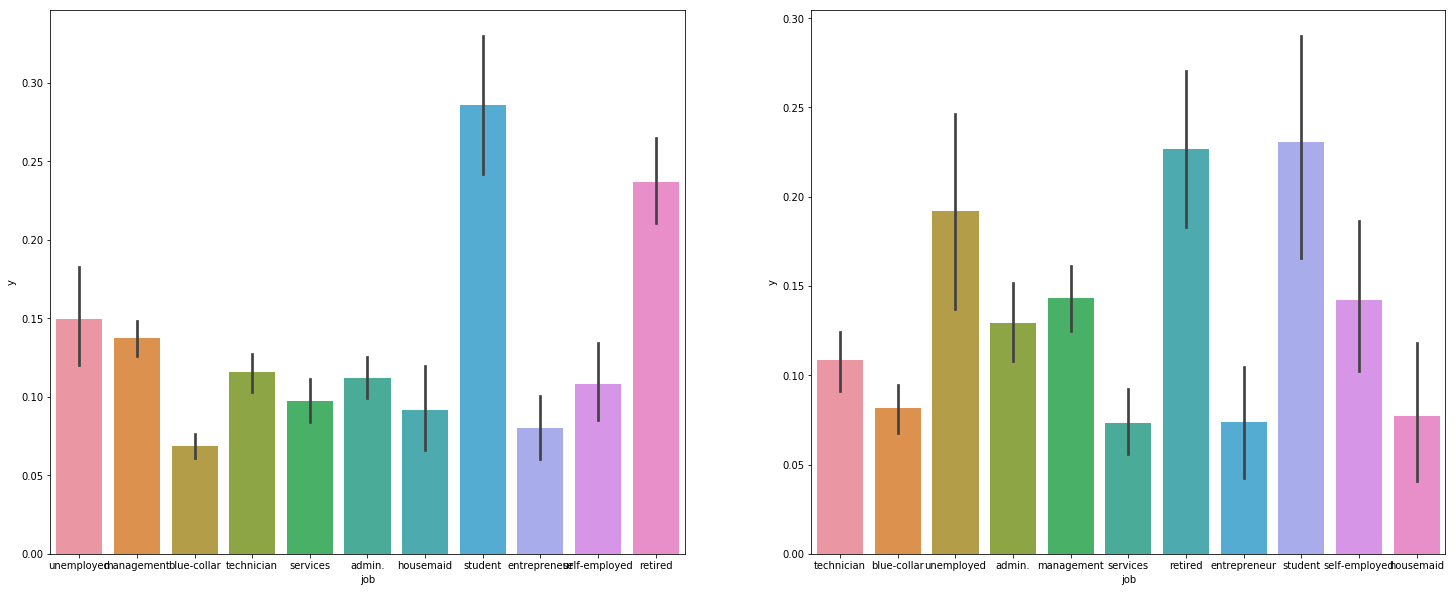

In [26]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(25,10))
sns.barplot('job', 'y', data=X_train, ax=axis1) 
sns.barplot('job', 'y', data=X_test, ax=axis2) 

我们通过上图，发现`retired`和`student`的比例相对较高，也就是说，该特征，是非常好的统计特征，因为这个`job`是一个categorical数据，所以我会将其直接进行`get_dummies`

In [27]:
# 我们同时，将所有的训练集数据集，以及从所有训练集中切好的训练集和测试集，都进行`one hot`操作
X_train = pd.get_dummies(data= X_train, columns=['job'])
X_test  = pd.get_dummies(data= X_test, columns=['job'])

train   = pd.get_dummies(data= train, columns=['job'])
test    = pd.get_dummies(data= test, columns=['job'])
X_train

,age,marital,education,default,balance,housing,loan,contact,day,month,...,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
18873,32,single,secondary,no,747,yes,no,cellular,8,may,...,0,0,0,0,0,0,0,0,0,1
13019,36,single,tertiary,no,3875,yes,no,cellular,27,may,...,0,0,0,1,0,0,0,0,0,0
470,37,single,tertiary,no,8066,no,no,telephone,13,aug,...,0,0,0,1,0,0,0,0,0,0
478,55,married,tertiary,no,2366,yes,yes,cellular,30,jul,...,0,0,0,1,0,0,0,0,0,0
20388,44,married,secondary,no,337,yes,no,telephone,28,jul,...,1,0,0,0,0,0,0,0,0,0
13594,38,single,tertiary,no,6490,no,no,telephone,10,nov,...,0,0,0,1,0,0,0,0,0,0
13738,35,married,tertiary,no,8029,yes,no,cellular,26,may,...,0,0,0,0,0,0,0,0,1,0
5891,37,single,tertiary,no,147,no,no,cellular,7,may,...,0,0,0,0,0,0,0,0,1,0
3473,50,married,primary,no,334,no,no,cellular,27,aug,...,1,0,0,0,0,0,0,0,0,0
9493,37,married,tertiary,no,767,no,yes,cellular,2,feb,...,0,0,0,1,0,0,0,0,0,0


## 3.2 marital 特征

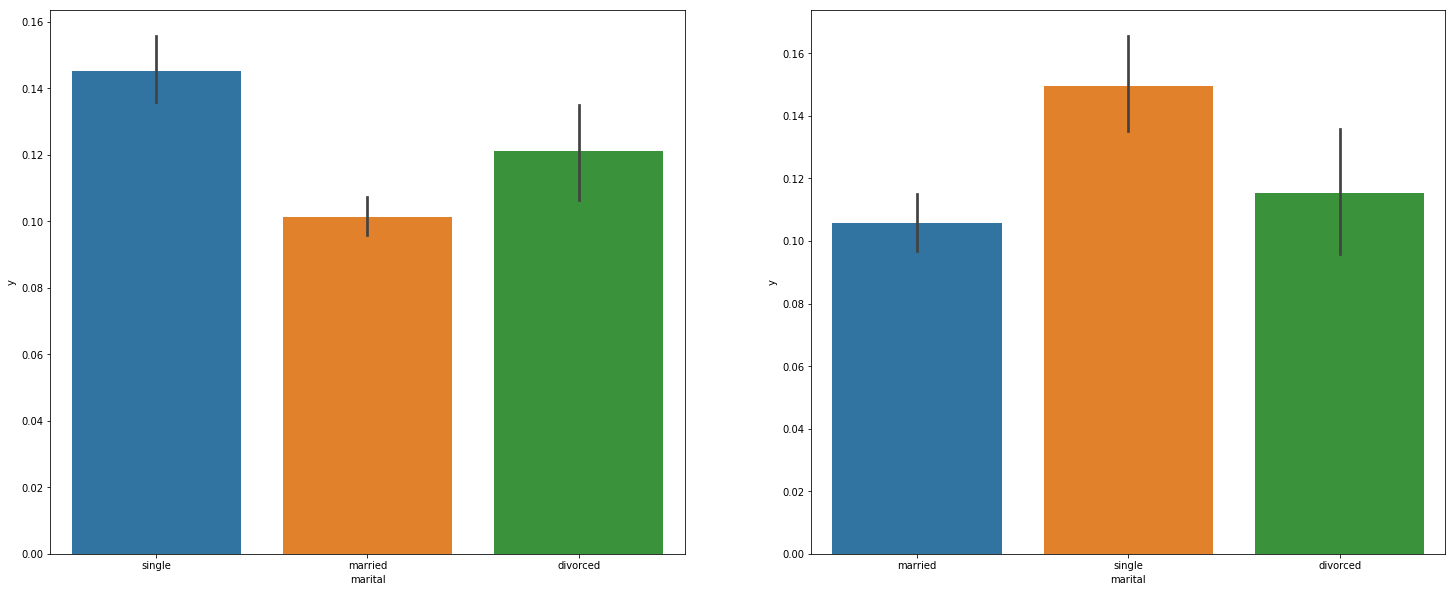

In [28]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(25,10))
sns.barplot('marital', 'y', data=X_train, ax=axis1) 
sns.barplot('marital', 'y', data=X_test, ax=axis2)

我们通过上图，发现`single`和`divorced`的比例相对较高，也就是说，该特征，是非常好的统计特征，因为这个marital是一个categorical数据，所以我会将其直接进行get_dummies

In [29]:
# 我们同时，将所有的训练集数据集，以及从所有训练集中切好的训练集和测试集，都进行`one hot`操作
X_train = pd.get_dummies(data = X_train, columns = ['marital'])
X_test  = pd.get_dummies(data = X_test, columns  = ['marital'])

train   = pd.get_dummies(data = train, columns = ['marital'])
test    = pd.get_dummies(data = test, columns  = ['marital'])

## 3.2 education特征

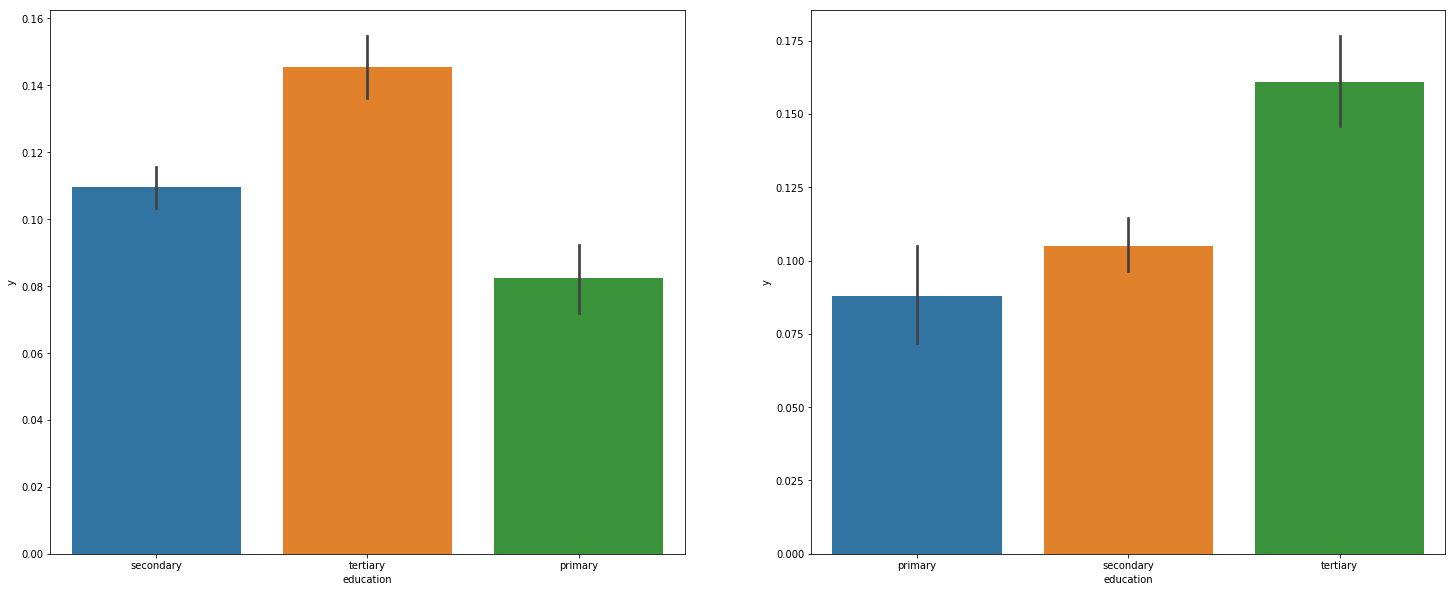

In [30]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(25,10))
sns.barplot('education', 'y', data=X_train, ax=axis1) 
sns.barplot('education', 'y', data=X_test, ax=axis2)

我们通过上图，发现tertisry和secondary education的比例相对较高，也就是说，该特征，是非常好的统计特征，因为这个education是一个categorical数据，所以我会将其直接进行get_dummies

In [31]:
# 我们同时，将所有的训练集数据集，以及从所有训练集中切好的训练集和测试集，都进行`one hot`操作
X_train = pd.get_dummies(data = X_train, columns = ['education'])
X_test  = pd.get_dummies(data = X_test, columns  = ['education'])

train   = pd.get_dummies(data = train,columns = ['education'])
test    = pd.get_dummies(data = test,columns = ['education'])

## 3.3 contact特征

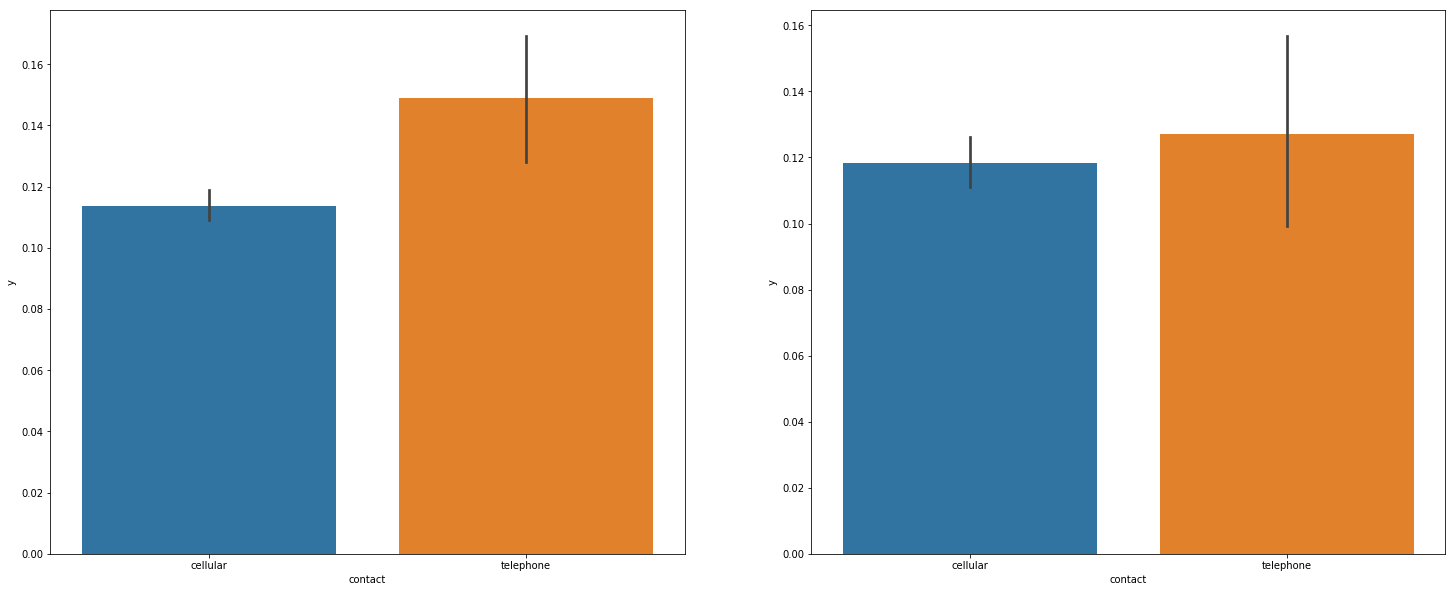

In [32]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(25,10))
sns.barplot('contact', 'y', data=X_train, ax=axis1) 
sns.barplot('contact', 'y', data=X_test, ax=axis2)

我们通过上图，发现telephone比例相对较高，也就是说，该特征，是非常好的统计特征，因为这contact是一个categorical数据，所以我会将其直接进行get_dummies

In [33]:
X_train = pd.get_dummies(data = X_train, columns = ['contact'])
X_test  = pd.get_dummies(data = X_test, columns  = ['contact'])

train   = pd.get_dummies(data= train, columns = ['contact'])
test    = pd.get_dummies(data= test, columns = ['contact'])

## 3.4 month特征

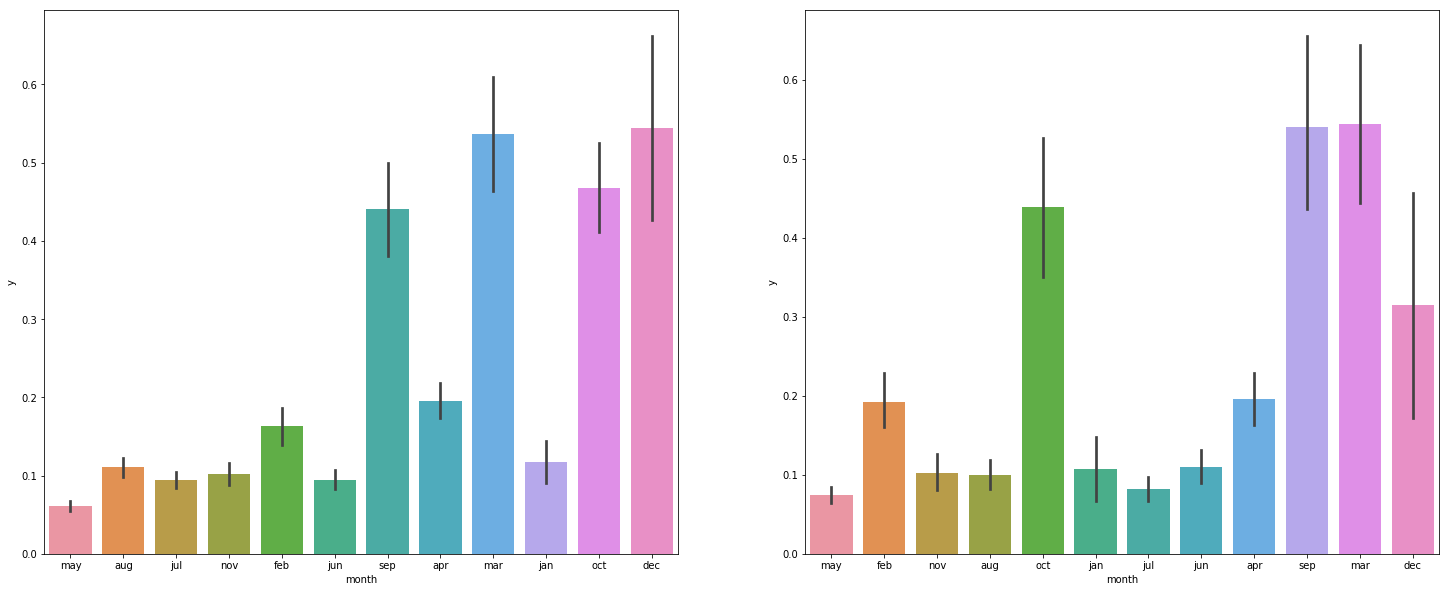

In [34]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(25,10))
sns.barplot('month', 'y', data=X_train, ax=axis1) 
sns.barplot('month', 'y', data=X_test, ax=axis2)

我们通过上图，发现`Mar`,`Oct`,`Sep`,和`Dec`比例相对较高，也就是说，该特征，是非常好的统计特征，因为这month是一个categorical数据，所以我会将其直接进行get_dummies

In [35]:
X_train = pd.get_dummies(data = X_train, columns = ['month'])
X_test  = pd.get_dummies(data = X_test, columns  = ['month'])

train   = pd.get_dummies(data = train, columns = ['month'])
test    = pd.get_dummies(data = test, columns = ['month'])

## 3.5 poutcome特征

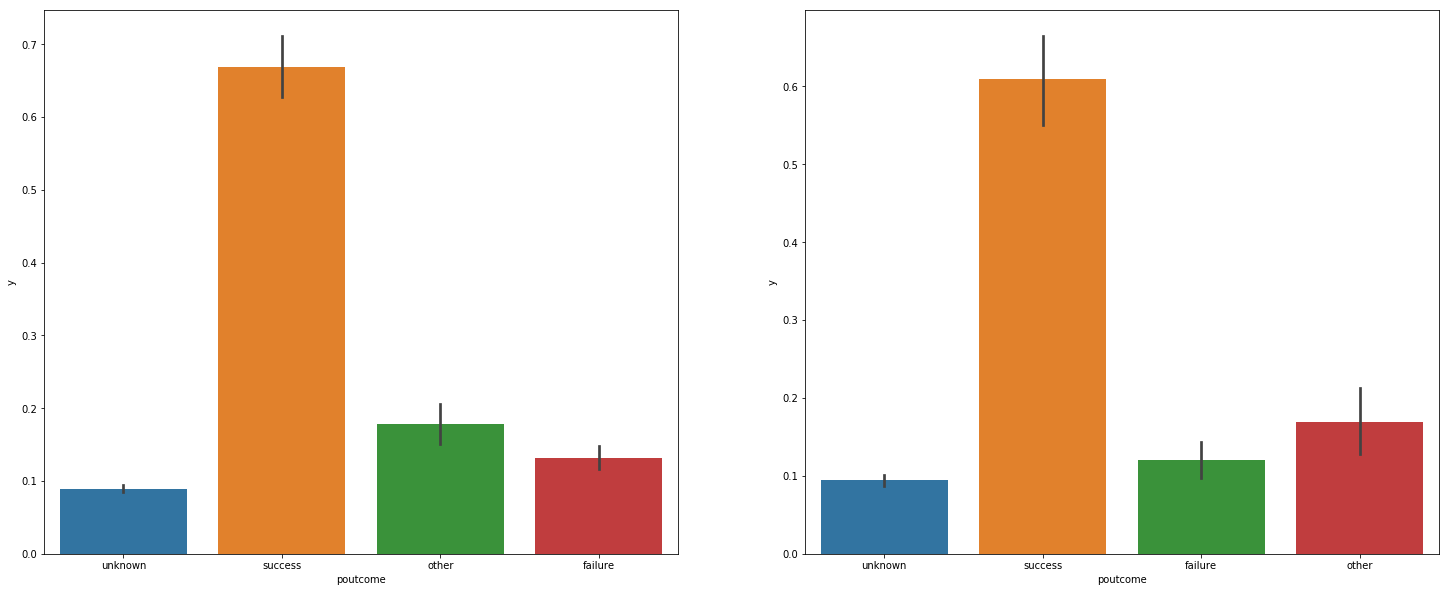

In [36]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(25,10))
sns.barplot('poutcome', 'y', data=X_train, ax=axis1) 
sns.barplot('poutcome', 'y', data=X_test, ax=axis2)

我们通过上图，发现success比例相对较高，也就是说，该特征，是非常好的统计特征，因为这poutcome是一个categorical数据，所以我会将其直接进行get_dummies

In [37]:
X_train = pd.get_dummies(data = X_train, columns = ['poutcome'])
X_test  = pd.get_dummies(data = X_test, columns  = ['poutcome'])

train = pd.get_dummies(data= train,columns=['poutcome'])
test = pd.get_dummies(data= test,columns=['poutcome'])

到上面为止，我已经对所有的非`yes`和`no`的categorical数据进行了处理，接下来我们将对`yes`和`no`类的`categorical`数据进行处理

## 3.6 default 特征

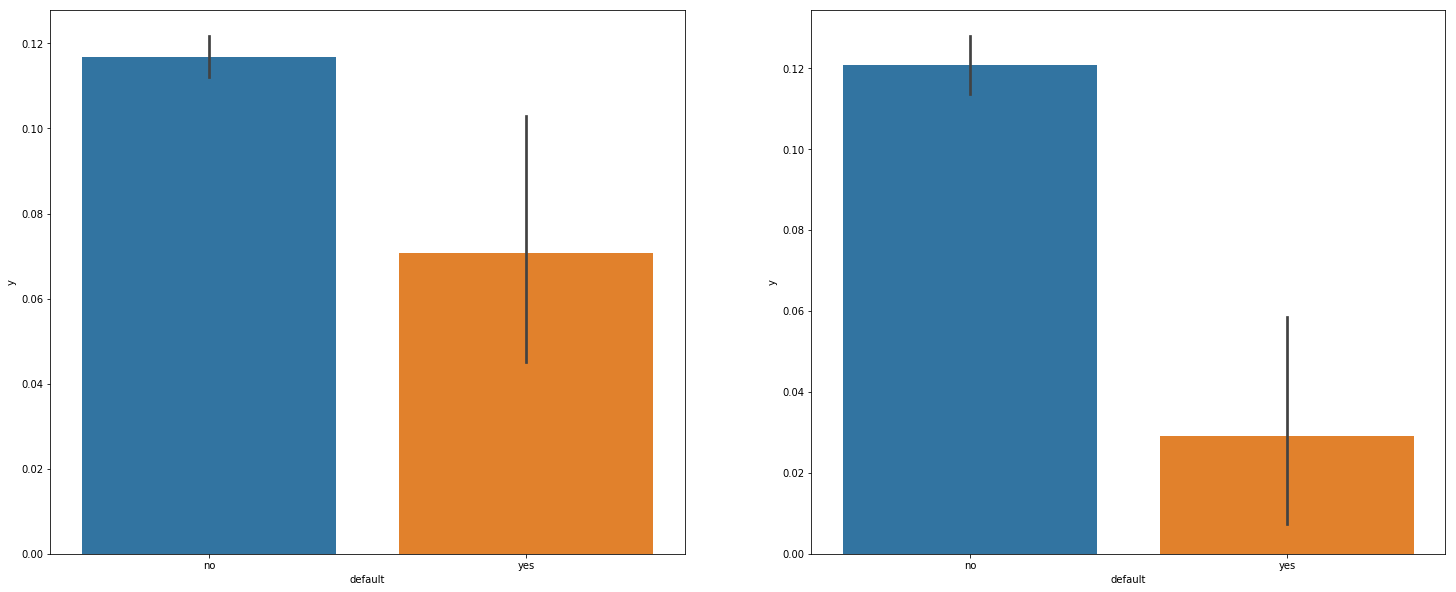

In [38]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(25,10))
sns.barplot('default', 'y', data=X_train, ax=axis1) 
sns.barplot('default', 'y', data=X_test, ax=axis2)

In [39]:
X_train['default'] = X_train['default'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['default']  = X_test['default'].apply(lambda x: 1 if x == 'yes' else 0)


train['default']   = train['default'].apply(lambda x: 1 if x == 'yes' else 0)
test['default']    = test['default'].apply(lambda x: 1 if x == 'yes' else 0)

X_train = pd.get_dummies(data= X_train, columns=['default'])
X_test  = pd.get_dummies(data= X_test, columns=['default'])

train   = pd.get_dummies(data= train, columns=['default'])
test    = pd.get_dummies(data= test, columns=['default'])

## 3.7 housing 特征

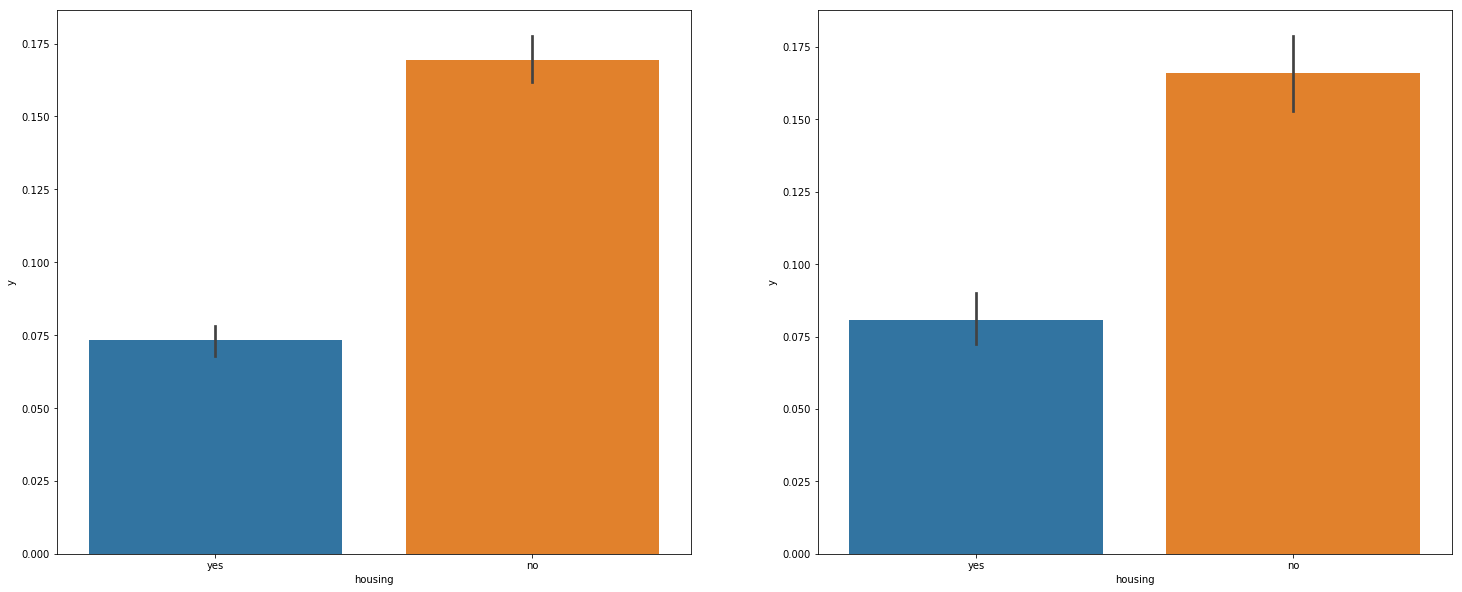

In [40]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(25,10))
sns.barplot('housing', 'y', data=X_train, ax=axis1) 
sns.barplot('housing', 'y', data=X_test, ax=axis2)

In [41]:
X_train['housing'] = X_train['housing'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['housing']  = X_test['housing'].apply(lambda x: 1 if x == 'yes' else 0)


train['housing']   = train['housing'].apply(lambda x: 1 if x == 'yes' else 0)
test['housing']    = test['housing'].apply(lambda x: 1 if x == 'yes' else 0)

X_train = pd.get_dummies(data= X_train, columns=['housing'])
X_test  = pd.get_dummies(data= X_test, columns=['housing'])

train   = pd.get_dummies(data= train, columns=['housing'])
test    = pd.get_dummies(data= test, columns=['housing'])

 ## 3.8 loan 特征

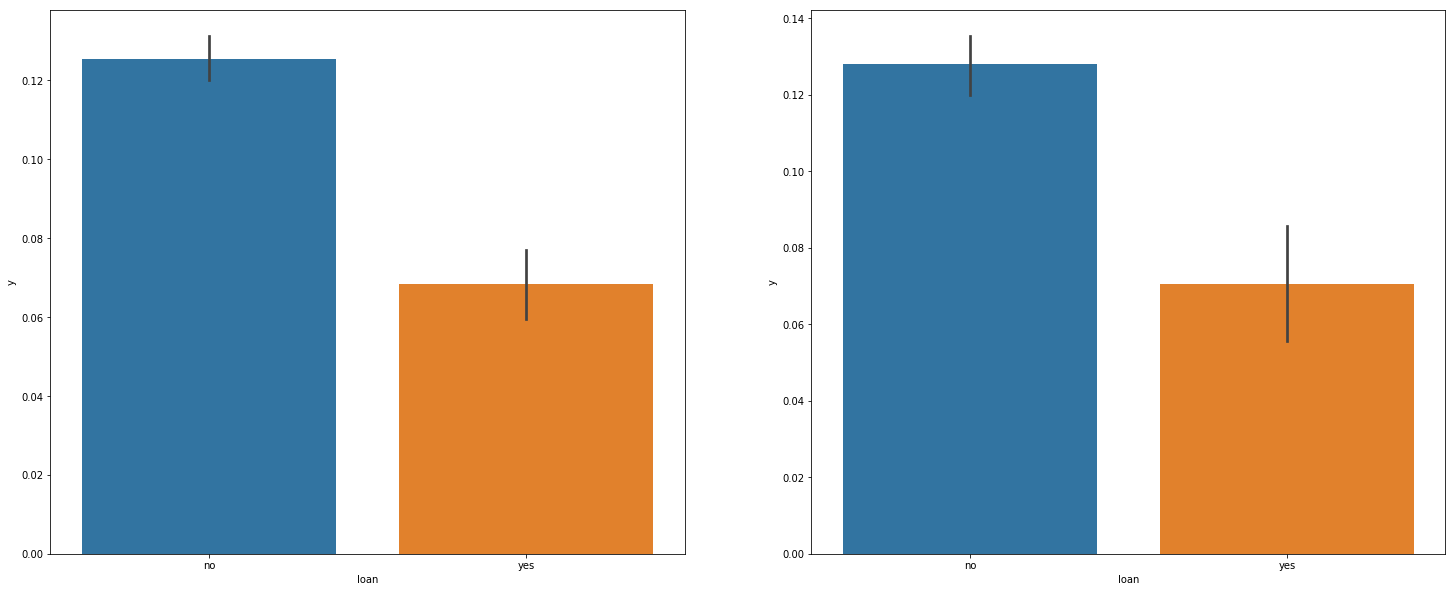

In [42]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(25,10))
sns.barplot('loan', 'y', data=X_train, ax=axis1) 
sns.barplot('loan', 'y', data=X_test, ax=axis2)

In [43]:
X_train['loan'] = X_train['loan'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['loan']  = X_test['loan'].apply(lambda x: 1 if x == 'yes' else 0)


train['loan']   = train['loan'].apply(lambda x: 1 if x == 'yes' else 0)
test['loan']    = test['loan'].apply(lambda x: 1 if x == 'yes' else 0)

X_train = pd.get_dummies(data= X_train, columns=['loan'])
X_test  = pd.get_dummies(data= X_test, columns=['loan'])

train   = pd.get_dummies(data= train, columns=['loan'])
test    = pd.get_dummies(data= test, columns=['loan'])

# 4. 模型选择
在这里，看到群里有朋友推荐`GradientBoostingClassifier`，我也选择了这个模型

In [44]:
X_train.drop('y', axis = 1, inplace =True)
X_test.drop('y',  axis = 1, inplace =True)


# creat model，首先是最简单的模型
gbm0 = GradientBoostingClassifier(random_state=10)
gbm0.fit(train,label) #这个模型的线上分数为0.91923616

y_pred = gbm0.predict(X_test)
y_predprob = gbm0.predict_proba(X_test)
y_predprob = y_predprob[:,1]

print("Accuracy : %.4g" % metrics.accuracy_score(Y_test, y_pred))
print("AUC Score (Train): %f" % metrics.roc_auc_score(Y_test, y_predprob))

Accuracy : 0.9115
AUC Score (Train): 0.929138


接下来，对模型进行调参

In [45]:
#优化n_estimators
param_test1 = {'n_estimators': list(range(20, 81, 10))}
gsearch1 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, min_samples_split=300, min_samples_leaf=20, max_depth=8,
                                         max_features='sqrt', subsample=0.8, random_state=10),
    param_grid=param_test1, scoring='roc_auc', iid=False, cv=5)
gsearch1.fit(train, label)
print(gsearch1.cv_results_['mean_test_score'],'\n', gsearch1.best_params_,'\n', gsearch1.best_score_)

[0.91193329 0.91586382 0.91950421 0.92171577 0.9226987  0.92376624
 0.92430543] 
 {'n_estimators': 80} 
 0.924305427217386


In [46]:
#优化max_depth
param_test2 = {'max_depth': list(range(3, 14, 2))}
gsearch2 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, min_samples_leaf=20,
                                         max_features='sqrt', subsample=0.8, random_state=10),
    param_grid=param_test2, scoring='roc_auc', iid=False, cv=5)
gsearch2.fit(train, label)
print(gsearch2.cv_results_['mean_test_score'],'\n', gsearch2.best_params_,'\n', gsearch2.best_score_)

[0.9134723  0.92230151 0.92454497 0.9253162  0.92613155 0.92573759] 
 {'max_depth': 11} 
 0.9261315507875665


In [47]:
#优化min_samples_split和min_samples_leaf
param_test3 = {'min_samples_split': list(range(500, 1201, 200)), 'min_samples_leaf': list(range(50, 101, 10))}
gsearch3 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth=11,
                                         max_features='sqrt', subsample=0.8, random_state=10,
                                        ),
    param_grid=param_test3, scoring='roc_auc', iid=False, cv=5)
gsearch3.fit(train, label)
print(gsearch3.cv_results_['mean_test_score'],'\n', gsearch3.best_params_,'\n', gsearch3.best_score_)

[0.92449494 0.92356725 0.92276774 0.9226288  0.92326325 0.92286904
 0.92284526 0.92170393 0.92214738 0.92188467 0.92166412 0.9208282
 0.92239044 0.92208084 0.92103543 0.92120259 0.92228726 0.92208637
 0.92216875 0.92067022 0.92199652 0.92112404 0.92138799 0.91921359] 
 {'min_samples_leaf': 50, 'min_samples_split': 500} 
 0.9244949367125374


In [48]:
#优化max_features
param_test4 = {'max_features': list(range(5, 20, 2))}
gsearch4 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth=11,
                                          subsample=0.8, random_state=10,
                                          min_samples_leaf=80, min_samples_split=800),
    param_grid=param_test4, scoring='roc_auc', iid=False, cv=5)
gsearch4.fit(train, label)
print(gsearch4.cv_results_['mean_test_score'],'\n', gsearch4.best_params_,'\n', gsearch4.best_score_)

[0.92054299 0.92331241 0.92331565 0.92425874 0.9238493  0.92357114
 0.92505109 0.92473983] 
 {'max_features': 17} 
 0.9250510895061556


In [49]:
#优化subsample
param_test5 = {'subsample': [0.6 ,0.65, 0.7, 0.75, 0.8, 0.85, 0.9]}
gsearch5 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth=11,
                                         max_features=15, random_state=10,
                                          min_samples_leaf=80, min_samples_split=500),
    param_grid=param_test5, scoring='roc_auc', iid=False, cv=5)
gsearch5.fit(train, label)
print(gsearch5.cv_results_['mean_test_score'],'\n', gsearch5.best_params_,'\n', gsearch5.best_score_)

[0.92382918 0.92340442 0.92496523 0.92497251 0.92487026 0.92476879
 0.92592026] 
 {'subsample': 0.9} 
 0.9259202554064313


In [50]:
#优化learning rate
param_test6 = {'learning_rate':[0.01, 0.1 , 0.3, 0.5 , 0.7, 1, 5]}
gsearch6 = GridSearchCV(
    estimator=GradientBoostingClassifier(subsample=0.9, n_estimators=80, max_depth=11,
                                         max_features=15, random_state=10,
                                          min_samples_leaf=80, min_samples_split=500),
    param_grid=param_test6, scoring='roc_auc', iid=False, cv=5)
gsearch6.fit(train, label)
print(gsearch6.best_params_, gsearch6.best_score_)

{'learning_rate': 0.1} 0.9259202554064313


In [ ]:
#（1）learning_rate=0.1, n_estimators=80,max_depth=11, min_samples_leaf =80, min_samples_split =500, max_features=15, subsample=0.9, random_state=10

In [51]:
gbm1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=11, min_samples_leaf =80, 
               min_samples_split =500, max_features=15, subsample=0.9, random_state=10)
gbm1.fit(train,label)

y_pred = gbm1.predict(X_test)
y_predprob = gbm1.predict_proba(X_test)
y_predprob = y_predprob[:,1]

print("Accuracy : %.4g" % metrics.accuracy_score(Y_test, y_pred))
print("AUC Score (Train): %f" % metrics.roc_auc_score(Y_test, y_predprob))

Accuracy : 0.9193
AUC Score (Train): 0.950570


In [52]:
y_pred = gbm1.predict(test)
y_predprob = gbm1.predict_proba(test)
y_predprob = y_predprob[:,1]

ID = list(range(25318,36170))
submission = pd.DataFrame(ID)

submission.rename(columns = {0: 'ID'}, inplace = True)

# 将pred_y从array转化成DataFrame
y_predprob = pd.DataFrame(y_predprob)
submission['pred'] =y_predprob
submission.to_csv('Result.csv', index = False)
print("Done!")

Done!
